In [ ]:
!pip install importlib-metadata==4.13.0
!pip install dionysus
!pip install gudhi
!pip install networkx
!pip install persim
!pip install xarray
!pip install validclust
!pip install POT==0.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.7 MB/s 
  Created wheel for dionysus: filename=dionysus-2.0.8-cp38-cp38-linux_x86_64.whl size=319866 sha256=e8b3bf7833d1ac051735e7949e83e330c8c16d8056649f25302c7bc48fc8f281
  Stored in directory: /root/.cache/pip/wheels/0e/6a/ce/a54c9248873852edfaf8e6e801db84c2d2c64f797fc07a68da
Successfully built dionysus
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 28.8 MB 1.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 3.5 MB/s 
  Created wheel for hopcroftkarp: 

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/My Drive/NASA")
!ls -ltr

total 7738
-rw------- 1 root root    1667 Oct  5 18:53  zigzagtools.py
-rw------- 1 root root   85452 Oct  5 18:53  zigzag_PD_eps_1.pdf
-rw------- 1 root root       0 Oct  5 18:53  VRrips.pk
-rw------- 1 root root  133051 Oct  5 18:53  PIs_labelled_modulo_month.pdf
-rw------- 1 root root  132779 Oct  5 18:53  PIs_labelled_modulo_month_1.pdf
-rw------- 1 root root  105850 Oct  5 18:53  PIs_labelled_modulo_month_0.pdf
-rw------- 1 root root  127787 Oct  5 18:53  PIs_labelled_1.pdf
-rw------- 1 root root  116243 Oct  5 18:53  PIs_labelled_0.pdf
-rw------- 1 root root  253295 Oct  5 18:53  PClouds.pdf
-rw------- 1 root root 1682280 Oct  5 18:53  Merra_t2m_freudenthal_Oct_2022.ipynb
-rw------- 1 root root  324306 Oct  5 18:53  Merra_t2m_freudenthal.ipynb
-rw------- 1 root root  323836 Oct  5 18:53  MERRA2_t2m_GP_20210201-20210228.nc
-rw------- 1 root root 1690684 Oct  5 18:53  MERRA2_t2m_CONUS_20210201-20210228.nc
-rw------- 1 root root  527019 Oct  5 18:53  MERRA2_t2m_CONUS_20210201-202102

In [ ]:
import numpy as np
import dionysus as d
import matplotlib.pyplot as plt
import time
import netCDF4
import sys
import time

In [ ]:
import os
import xarray as xr

In [ ]:
path = os.getcwd()
#%% Parameters 
#nameFolderCloud = path + '/PointCloud/5_Dimensions/datafullpc'  # Example 1 (Dorcas)  (sizeWindow = 10) * It has not any interesting structures
#nameFolderCloud = path + '/PointCloud/FIG8Saved_40/File'  # Example 2  (sizeWindow = 12)
#nameFolderCloud = path + '/../Example_POINT_CLOUD/PointCloud/FIG8Saved_60/File'  # Example 3  (sizeWindow = 12)
#scaleParameter = 1.0 # [Example 2 and 3] Maximum Scale Parameter for Filtration (Depends on distance between points)
#scaleParameter = 9.0 # [Example 1] Maximum Scale Parameter for Filtration (Depends on distance between points)
maxDimHoles = 2 # Maximum Dimension of Holes (It means.. 0 and 1)
sizeWindow = 28 # [Example 2 and 3] Number of Point-Clouds (i.e. timestamps) 
#sizeWindow = 10 # [Example 1] Number of Point-Clouds (i.e. timestamps) 

In [ ]:
fname = 'MERRA2_t2m_GP_20210201-20210228.nc'
ds = xr.open_dataset(fname)
data = ds['t2m'].squeeze()


print (np.array(data[0,:, :]))

[[288.49606323 289.03155518 287.08218384 ... 282.00143433 282.7444458
  283.34893799]
 [286.56442261 286.54849243 284.95831299 ... 281.21334839 281.68276978
  281.62319946]
 [283.40982056 283.60250854 282.26071167 ... 280.56246948 280.49966431
  280.5128479 ]
 ...
 [272.62832642 272.45513916 272.47271729 ... 265.21435547 265.72332764
  265.02468872]
 [272.60656738 272.92019653 272.78347778 ... 264.9175415  265.2008667
  264.56951904]
 [275.76651001 275.35919189 274.49002075 ... 264.76290894 264.65261841
  263.64828491]]


In [ ]:
def shift_filtration(rips,n):
    "Take a Dionysus filtration and increase the name of all of the vertices by n."
    f = d.Filtration()
    for s in rips:
        dim = s.dimension()
        temp = []
        for i in range(0,dim+1):
            temp.append(s[i]+n)
        f.append(d.Simplex(temp,s.data))
    return f

def get_verts(simp):
    '''
    Helper function to get all vertices of the input simplex

    Parameters
    -----------
    simp: dio.Simplex
        Instance of Dionysus simplex class

    Returns
    -------
    List of vertices in the simplex

    '''
    if simp.dimension == 2:
        return [d.Simplex([v], 0) for v in t]
    else:
        return set([s for s in simp.boundary()])

def fix_dio_vert_nums(Cplx, vertind):
    '''
    Helper function to adjust indexing of vertices in Dionysus from ``fill_rips`` function.

    Cplx: List of dio.Simplex's or a dio.Filtration
        Starting complex you want to adjust indices of

    vertind: int
        Starting index for vertices

    Returns
    -------
    New complex with vertex indices adjusted by vertind.

    '''
    New_Cplx = []
    for s in Cplx:
        # s.data = data
        vlist = []
        for v in s:
            vlist.append(v+vertind)
        s = d.Simplex(vlist, s.data)

        New_Cplx.append(s)
    return New_Cplx

In [ ]:
def setup_Zigzag_fixed(lst, verbose=False):
    '''
    Helper function for ``run_Zigzag`` that sets up inputs needed for Dionysus' zigzag persistence function.
    This only works for a fixed radius r.

    Parameters
    ----------

    r: float
        Radius for rips complex

    k: int, optional
        Max dimension for rips complex (default is 2)

    verbose: bool, optional
        If true, prints updates when running code

    Returns
    -------
    filtration: dio.Filtration
        Dionysis filtration containing all simplices that exist in zigzag sequence

    times: list
        List of times, where times[i] is a list containing [a,b] where simplex i appears at time a, and disappears at time b

    '''

    simps_list = []
    times_list = []

    # Initialize A with R(X_0)
    rips = d.fill_freudenthal(lst[0])
    rips.sort()
    rips_set = set(rips)

    # Initialize A with set of simplices with verts in X_0
    A = rips_set
    print (A)
    # # Add all simps to the list with birth,death=[0,1]
    simps_list = simps_list + [s for s in A]
    times_list = times_list + [[0, 1] for j in range(len(A))]

    for i in range(1, len(lst)):

        # Calculate rips of X_{i-1} \cup X_i
        rips = d.fill_rips(np.vstack([lst[i-1], lst[i]]))
        rips = shift_filtration(rips, (i-1) * pointNum)

        # Set of vertices in R(X_i)
        B = d.fill_freudenthal(lst[i])
        B = shift_filtration(B, i * pointNum)

        print (set(B))
        # Set of simplices with verts in X_{i-1} AND X_{i}
        M = set()

        # Loop over vertices in R(X_{i-1} \cup R_i)
        for simp in rips:
            
            # Get list of vertices of simp
            bdy = get_verts(simp)
            #print ('Simplex {} has vertices {}'.format(simp, bdy))
            # If it has no boundary and its in B, its a vertex in B and has been handled
            if not bdy:
                continue

            # If all of its verts are in A, it's been handled in the initialization or the previous iteration
            if bdy.intersection(A) == bdy:
                continue

            # If all of its verts are in B, add it to B
            elif bdy.intersection(B) == bdy:
                #print (simp)
                continue

            # If it has some verts in A and some in B, it only exists in the union
            # Add it to M
            else:
                M.add(simp)
        
        print (M)
        # Add simplices in B with the corresponding birth,death times
        simps_list = simps_list + [s for s in B]
        times_list = times_list + [[i-0.5, i+1] for j in range(len(B))]
        #print (M)
        # Add simplicies in M with corresponding birth,death times
        simps_list = simps_list + [s for s in M]
        times_list = times_list + [[i-0.5, i] for j in range(len(M))]

        # Reinitialize for next iteration
        A = B

    filtration = d.Filtration(simps_list)

    print ('length of time list: {}'.format(len(times_list)))
    print ('length of simp list: {}'.format(len(simps_list)))
    print ('length of filtration: {}'.format(len(filtration)))

    return filtration, times_list

In [ ]:
# Get point cloud at each time step
merraFeb1 =  np.array(data[0,:, :]) 
merraFeb2 =  np.array(data[1,:, :])
merraFeb3 =  np.array(data[2,:, :])
merraFeb4 =  np.array(data[3,:, :])
merraFeb5 =  np.array(data[4,:, :])
merraFeb6 =  np.array(data[5,:, :])
merraFeb7 =  np.array(data[6,:, :])

testDataset = [merraFeb1, merraFeb2, merraFeb3, merraFeb4, merraFeb5, merraFeb6, merraFeb7]

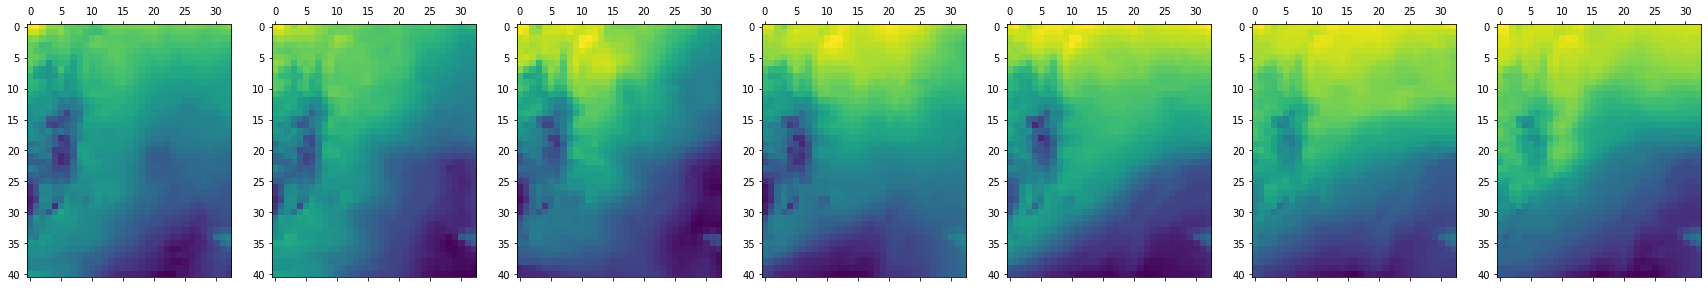

In [ ]:
fig = plt.figure(figsize=(30, 6))
ax1 = fig.add_subplot(171)
ax1.matshow(merraFeb1)
ax2 = fig.add_subplot(172)
ax2.matshow(merraFeb2)
ax3 = fig.add_subplot(173)
ax3.matshow(merraFeb3)
ax4 = fig.add_subplot(174)
ax4.matshow(merraFeb4)
ax5 = fig.add_subplot(175)
ax5.matshow(merraFeb5)
ax6 = fig.add_subplot(176)
ax6.matshow(merraFeb6)
ax7 = fig.add_subplot(177)
ax7.matshow(merraFeb7)

In [ ]:
nday = 2
dataset = [np.array(data[i,:, :]) for i in range(nday)]

In [ ]:
filtration, time_list = setup_Zigzag_fixed(dataset) # point cloud at each time step is a 41 * 33 matrix

Streaming output truncated to the last 5000 lines.
<2479> 277.209
<2446,2479> 277.209
<2479,2480> 277.209
<2446,2479,2480> 277.209
<1804> 277.236
<1804,1805> 277.236
<1804,1837> 277.236
<1804,1838> 277.236
<1804,1805,1838> 277.236
<1804,1837,1838> 277.236
<2383> 277.244
<2350,2383> 277.244
<2383,2384> 277.244
<2383,2417> 277.244
<2350,2383,2384> 277.244
<2383,2384,2417> 277.244
<2414> 277.247
<2413,2414> 277.247
<2414,2447> 277.247
<2414,2448> 277.247
<2413,2414,2447> 277.247
<2414,2447,2448> 277.247
<254> 277.263
<254,255> 277.263
<254,287> 277.263
<254,288> 277.263
<254,255,288> 277.263
<254,287,288> 277.263
<299> 277.264
<265,299> 277.264
<266,299> 277.264
<299,300> 277.264
<299,332> 277.264
<299,333> 277.264
<265,266,299> 277.264
<266,299,300> 277.264
<299,300,333> 277.264
<299,332,333> 277.264
<316> 277.265
<316,317> 277.265
<316,349> 277.265
<316,350> 277.265
<316,317,350> 277.265
<316,349,350> 277.265
<302> 277.266
<268,302> 277.266
<301,302> 277.266
<302,303> 277.266
<302,335> 

In [ ]:
np.random.seed(0)
pointNum = 300

values = np.random.rand(pointNum) - 0.5

x = np.linspace(0, 20, pointNum)
y1 = 0.05 * np.sin(x) + (1/8) * values
y2 = 0.2 * np.sin(x) + (1/2) * values
y3 = 0.7 * np.sin(x) + (1/7) * values
y4 = 1.0 * np.sin(x) + 0.01 * values
y5 = 0.6 * np.sin(x) + (1/6) * values
y6 = 0.15 * np.sin(x) + (1/1.5) * values
y7 = 0.03 * np.sin(x) + (1/8) * values
y = np.array([y1, y2, y3, y4, y5, y6])

filtration, time_list = setup_Zigzag_fixed(y)
print (time_list)

{<33> 0.0487615, <78,79> -0.0692411, <81> -0.0487759, <280> -0.0318809, <215> 0.080815, <72,73> 0.00986355, <221> 0.086523, <4> 0.00367573, <27> 0.104207, <227> -0.0105434, <126> -0.0181171, <88,89> 0.0374595, <64> -0.0833452, <101> -0.00598586, <64,65> -0.0631233, <84,85> -0.0225064, <165,166> -0.00548212, <187> 0.0083399, <247,248> -0.0759343, <231,232> 0.0116969, <137> 0.0320475, <145> 0.0119463, <44,45> 0.0307033, <198> -0.0238932, <281,282> 0.0409408, <13> 0.091402, <157,158> -0.0353869, <181,182> -0.00698335, <147,148> 0.0325967, <220,221> 0.086523, <105,106> 0.04762, <65> -0.0631233, <149> 0.0365729, <287> 0.0143363, <203,204> 0.00235111, <81,82> -0.0487759, <270,271> 0.0241919, <272> -0.0507109, <256> -0.0428764, <188,189> 0.0292093, <253> -0.0157875, <36> 0.0474881, <12,13> 0.091402, <96,97> 0.0177031, <159> -0.100647, <134,135> 0.0310132, <50> -0.0013004, <73,74> -0.0186892, <123,124> 0.0645526, <79> -0.089703, <118> 0.0976789, <135,136> 0.0305846, <37> 0.0455356, <298,299> 0

[Diagram with 1 points]
0 0.0 6.0


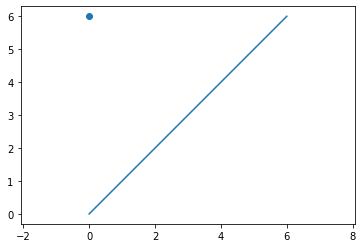

In [ ]:
zz, dgms, cells = d.zigzag_homology_persistence(filtration, time_list)
print(dgms)
for i, dgm in enumerate(dgms):
    for pt in dgm:
        print(i, pt.birth, pt.death)

d.plot.plot_diagram(dgms[0], show = True)
#d.plot.plot_diagram(dgms[1], show = True)